In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np


from xml.etree import ElementTree as ET
from mujoco_py import load_model_from_path
from scipy.stats import truncnorm

from shared_utils.general import get_project_root, remove_tmp_files, models_folder_path
from shared_utils.xacro import set_xacro_property, parse_xacro_to_xml
from xml_generation.utils import insert_generated_comment, save_xml_file
from inertia.assess_inertia import get_bodies_total_mass
from monte_carlo.sample_models import get_ua_aux_mass_sample, get_la_aux_mass_sample
from monte_carlo.constants import UA_MASS_MEAN, LA_MASS_MEAN, UA_AUX_MASS_MEAN, LA_AUX_MASS_MEAN
from monte_carlo.constants import UA_MASS_STD, LA_MASS_STD
from monte_carlo.constants import UA_AUX_MASS_LB, UA_AUX_MASS_UB, LA_AUX_MASS_UB, LA_AUX_MASS_LB

### Minimum mass given mjc model constraints

1. Set auxiliary mass to epsilon << total mass
2. Measure mass

In [4]:
ET.register_namespace('xacro', 'http://www.ros.org/wiki/xacro')

path_to_root = get_project_root()

relpath_to_script_tmp = os.path.join("bin", "outputs", "mc_tmp")
path_to_script_tmp = os.path.join(get_project_root(), relpath_to_script_tmp)
assert os.path.isdir(path_to_script_tmp)

# load original xacro model
path_to_xacro_orig = os.path.join(models_folder_path(), "exo_with_patient", "nesm_with_patient.xacro")
assert os.path.isfile(path_to_xacro_orig)
xacro_tree = ET.parse(path_to_xacro_orig)

xacro_root = xacro_tree.getroot()
insert_generated_comment(xacro_root)
edited_xacro_filename = "nesm_with_patient_tmp.xacro"
xml_filename = "nesm_with_patient_tmp.xml"

# set auxiliary masses to epsilon
mass_epsilon = .001
aux_mass_properties = ["M_ua", "M_la_1", "M_la_2"]

for prop in aux_mass_properties:
    set_xacro_property(xacro_root, prop, str(mass_epsilon))

# the xacro file will not be saved in the usual bin/models/exo_with_patient folder
# therefore the path to root property has to be adjusted
set_xacro_property(xacro_root, "path_to_root", "../../..")

# save the new xacro file in tmp
print("Saving xacro model...")
save_xml_file(xacro_root, edited_xacro_filename, path_to_script_tmp)

# parse newly generated xacro file into xml (uses xacro.sh)
print("Generating xml model...")
parse_xacro_to_xml(edited_xacro_filename,
                    xml_filename, relpath_to_script_tmp)

# load the model and do something
print("Loading xml model...")
model = load_model_from_path(
    os.path.join(path_to_script_tmp, xml_filename))

remove_tmp_files(path_to_script_tmp)

Saving xacro model...
Generating xml model...
Loading xml model...


In [5]:
# upper arm mass
ua_body_names = ["humerus_r", "ua_soft_collider"]
ua_mass = get_bodies_total_mass(ua_body_names, model)
print(f"Minimum upper arm mass: {ua_mass}")

# lower arm mass
la_body_names = ["ulna_r", "la_soft_collider", "radius_r"]
la_mass = get_bodies_total_mass(la_body_names, model)
print(f"Minimum lower arm mass: {la_mass}")

Minimum upper arm mass: 0.4900000000000004
Minimum lower arm mass: 0.35300000000000026


In [6]:
print(f"Upper arm mass bias: {get_bodies_total_mass(['ua_soft_collider'], model)}")
print(f"Lower arm mass bias: {get_bodies_total_mass(['la_soft_collider'], model)}")

Upper arm mass bias: 0.4890000000000004
Lower arm mass bias: 0.35100000000000026


### Average and std of arm mass

Source of anthropometric percentages: *ESTIMATION OF MASS MOMENT OF INERTIA OF HUMAN
BODY, WHEN BENDING FORWARD, FOR THE DESIGN OF A
SELF-TRANSFER ROBOTIC FACILITY*

Body weight stats: [Weight Height and Body Mass Index
Distributions in Geographically and Ethnically
Diverse Samples of Older Persons](https://watermark.silverchair.com/25-4-300.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAskwggLFBgkqhkiG9w0BBwagggK2MIICsgIBADCCAqsGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMQ9mtUhrUuTTH6kdFAgEQgIICfJ-uPCWkXfxmMW1oKh4dMKeMhTHV8_I4yE08sLYusb0eVWU-BMmuewIIL6Ln2oFNSKyHkewcBozvCRkNtNKiWeCVXYBsLkt4ulPPQ7s538diNeP8VV8MllKXbNkBJkjfrITdTr-QvVLoHdqFZnn4ZYDnlfrIhA44OKIQEVbKF_gkQncVUGE6rrr1yxGpk4-GmjSG19XPiXisfU0vfvcXZu5Uf8wQolQxXiGdX4omMJrrjvFI-gmmn30_9cgTVuo4Z1r7EptY8dWOL7u750vEIDzHqpGhgOt19rvIW4og3IHkMcj28Ad34dL9fXBSeh1xJwik0RAdAmycDAuH7FsgZClgZy457AsJh2ll7T_QG1WiEk_EVR4zd7AFIBfiPBCvXjgbcPa_G9aNiYmiPH5-IscvAOcl9XYKGky7uVw9vySPKsrgS-40rMXUSaNHV43lAN_-7eslxj5ELUQIdl_aAGJWgo79LLP4vSiN47ZKxqiMIxri_HiFfT00YLwgveZvU1ZmGoPaIbYGt6m7qpv6WnydqGcyJhHJTtHd-4YeGgljrt6o1CCDlFkiKQ4xnq7vl9hWWYsarJJsuTP-kz0EoemxafWcqJbRJ85SWNFQAsppdG66g-dMwkEQmq8e3l03xTHIOtxg_kouPUe3u0PduVpqfvvaXUec3JenNBeTLdTcqJKcyQ2OJ4yIwZkpaV3bFALQO0szAdzifwpUwrIwV1OOcaljguOXhRYGaB6XKkK8hcRQ0A4d-NqYpr7sJadR6m6v1k4RRKJvKV7ggPf25lnaLFkmWzQhNJ7uW-VgjtyCQ8EmKlK1ITc6naiREeVRT5oNa63RHQ6y7s8GdQ)

In [7]:
print(f"Mean upper arm mass: {UA_MASS_MEAN}")
print(f"Mean lower arm mass: {LA_MASS_MEAN}")

Mean upper arm mass: 2.25
Mean lower arm mass: 1.3125000000000002


In [8]:
print(f"Mean auxiliary upper arm mass: {UA_AUX_MASS_MEAN}")
print(f"Mean auxiliary lower arm mass: {LA_AUX_MASS_MEAN}")

Mean auxiliary upper arm mass: 1.7610000000000001
Mean auxiliary lower arm mass: 0.9615000000000002


In [9]:
print(f"Upper arm mass std: {UA_MASS_STD}")
print(f"Lower arm mass std: {LA_MASS_STD}")

Upper arm mass std: 0.36
Lower arm mass std: 0.21000000000000002


We have a margin of roughly 4 sigmas for truncated gaussian.

### Truncated gaussian model and sampler

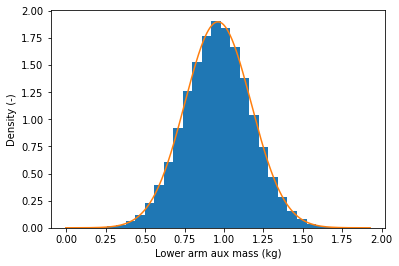

In [10]:
a, b = (LA_AUX_MASS_LB - LA_AUX_MASS_MEAN)/LA_MASS_STD, (LA_AUX_MASS_UB - LA_AUX_MASS_MEAN)/LA_MASS_STD
x_array = np.linspace(LA_AUX_MASS_LB-.005, LA_AUX_MASS_UB+.005, 400)

n_samples = (100000,)
plt.hist(get_la_aux_mass_sample(n_samples), density=True, bins=30)
plt.plot(x_array, truncnorm.pdf(x_array, a, b, loc=LA_AUX_MASS_MEAN, scale=LA_MASS_STD))
plt.xlabel("Lower arm aux mass (kg)")
plt.ylabel("Density (-)")
plt.show()

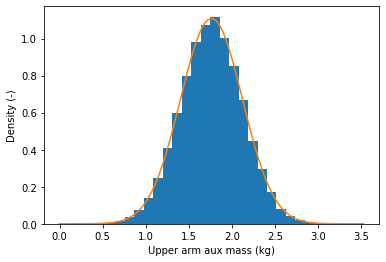

In [11]:
a, b = (UA_AUX_MASS_LB - UA_AUX_MASS_MEAN)/UA_MASS_STD, (UA_AUX_MASS_UB - UA_AUX_MASS_MEAN)/UA_MASS_STD
x_array = np.linspace(UA_AUX_MASS_LB-.005, UA_AUX_MASS_UB+.005, 400)

n_samples = (100000,)
plt.hist(get_ua_aux_mass_sample(n_samples), density=True, bins=30)
plt.plot(x_array, truncnorm.pdf(x_array, a, b, loc=UA_AUX_MASS_MEAN, scale=UA_MASS_STD))
plt.xlabel("Upper arm aux mass (kg)")
plt.ylabel("Density (-)")
plt.show()